# Trabajo semanal 9

Alumno: Francisco Manoukian

## Parte I: Diseño de los filtros

<img src="./ts9_consigna_1.svg" width="60%" align="left">

Se necesita eliminar las interferencias de una señal electrocardiográfica (ECG) que fue registrada a una frecuencia de muestreo de 1 kHz. Para ello se propone la siguiente plantilla de diseño, y se pide diseñar dos filtros: uno IIR y otro FIR que cumplan con la plantilla, utilizando alguno de los métodos estudiados. Mostrar la respuesta en frecuencia, para ambos filtros, de:

a) módulo, 

b) fase 

c) retardo 

d) y respuesta al impulso.

In [13]:
import warnings
warnings.filterwarnings('ignore')

import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

In [21]:
ripple = 0.01 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

wp = np.array([wp1,wp2])/nyq_frec
ws = np.array([ws1,ws2])/nyq_frec

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ])
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

## Diseño del filtro IIR

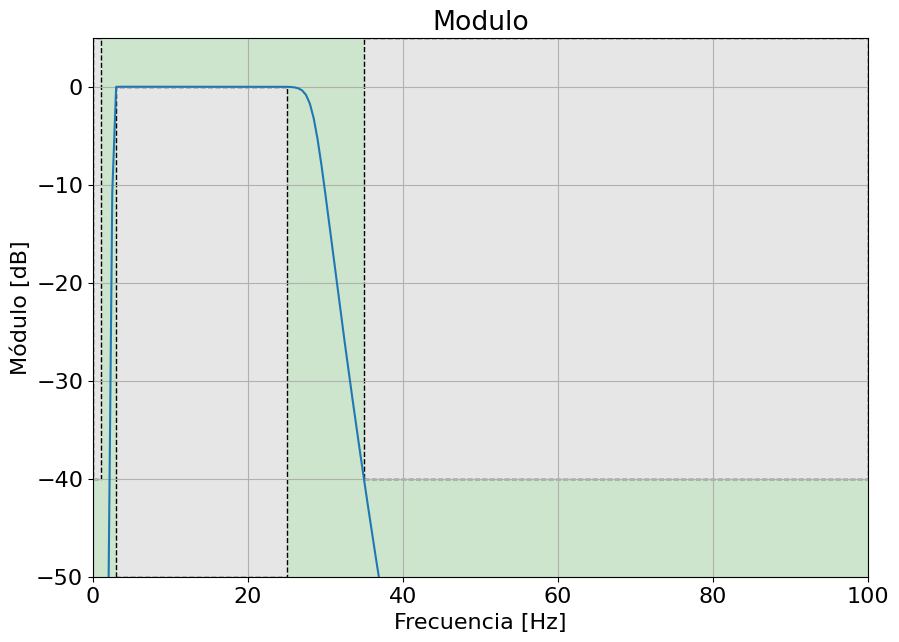

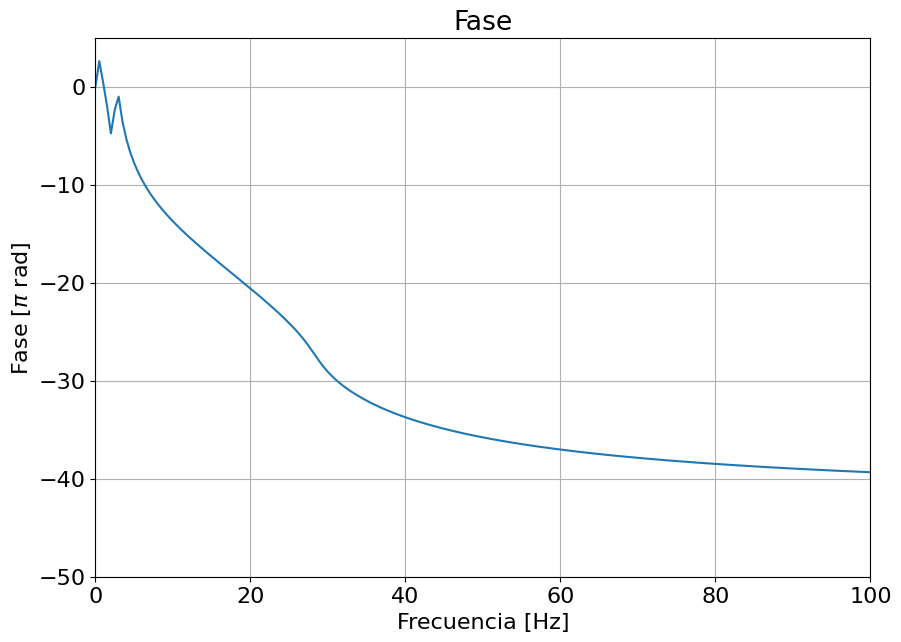

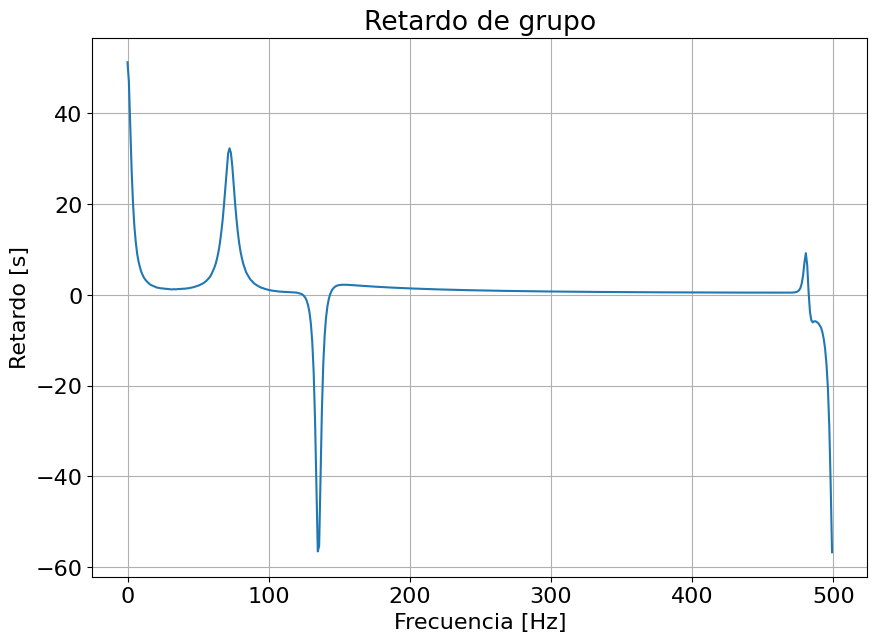

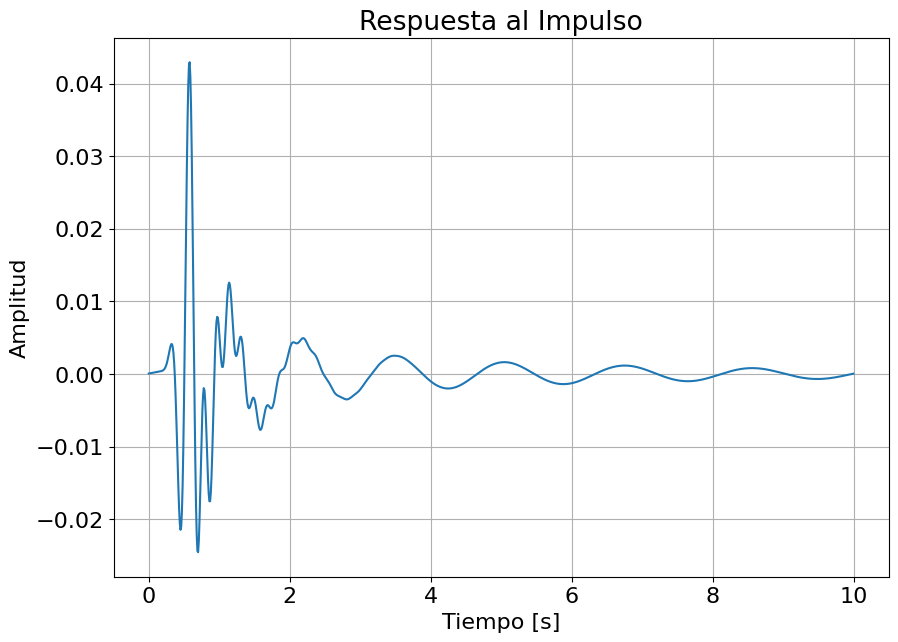

In [31]:
num, den = sig.iirdesign(wp, ws, ripple, atenuacion, analog=False, ftype='butter', output='ba')
sos_iir = sig.iirdesign(wp, ws, ripple, atenuacion, analog=False, ftype='butter', output='SOS')

w_h, h = sig.sosfreqz(sos_iir, worN=1000)
f_h = w_h/np.pi * nyq_frec

w_gd, gd = sig.group_delay((num, den))
f_gd = w_gd/np.pi * nyq_frec

t = np.arange(0, 10, 0.01)
imp = np.fft.ifft(h)

plt.figure()
plt.title('Modulo')
plt.plot(f_h, 20 * np.log10(abs(h)))
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0,100,-50, 5])

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]], ripple = ripple, 
               fstop = frecs[[1, 4]], attenuation = atenuacion, fs = fs)

plt.figure()
plt.title('Fase')
angles = np.unwrap(np.angle(h))
plt.plot(f_h, angles)
plt.ylabel('Fase [$\pi$ rad]')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.axis([0,100,-50, 5])
plt.show()

plt.figure()
plt.title('Retardo de grupo')
plt.plot(f_gd, gd)
plt.ylabel('Retardo [s]')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.show()

plt.figure()
plt.title('Respuesta al Impulso')
plt.plot(t, imp)
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.grid()
plt.show()

## Diseño del filtro FIR

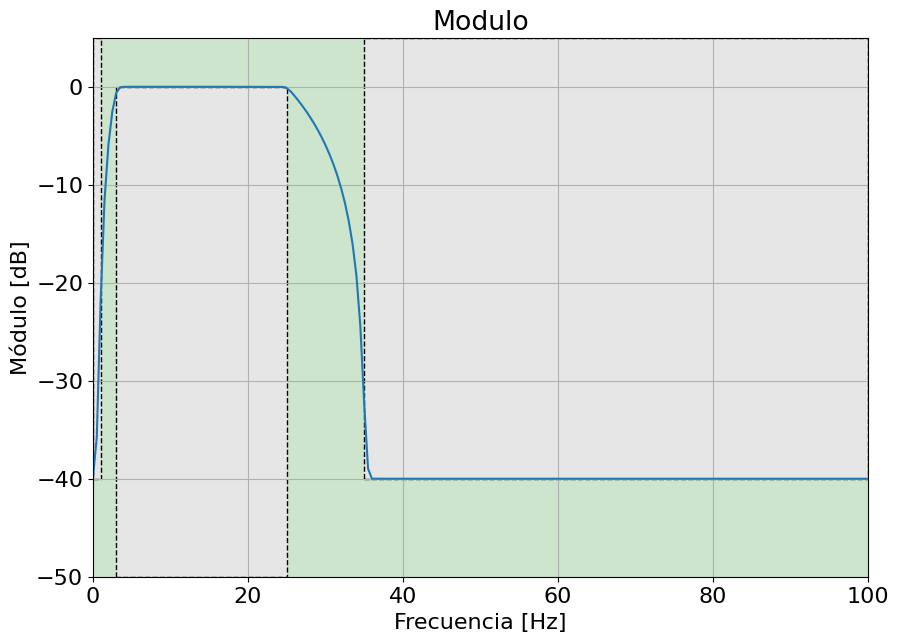

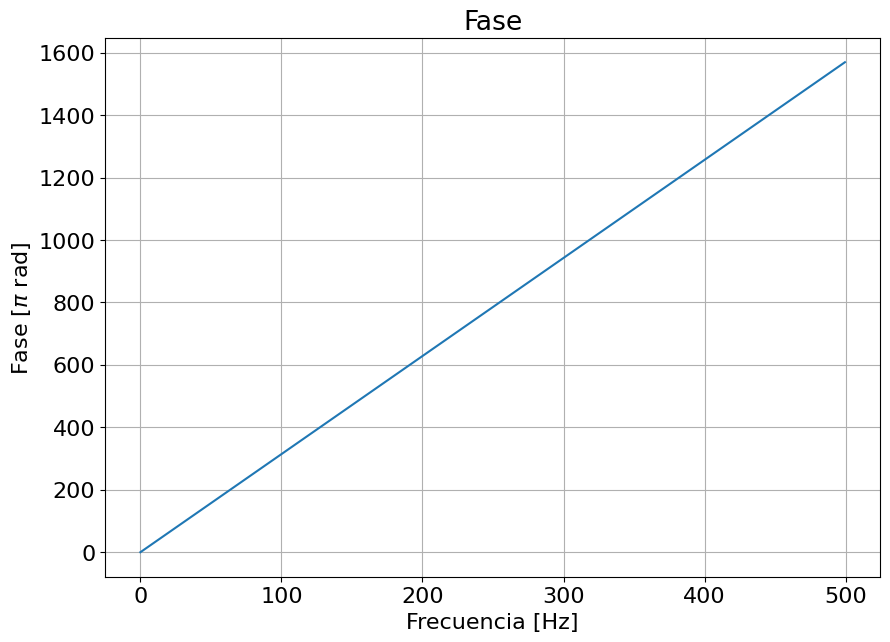

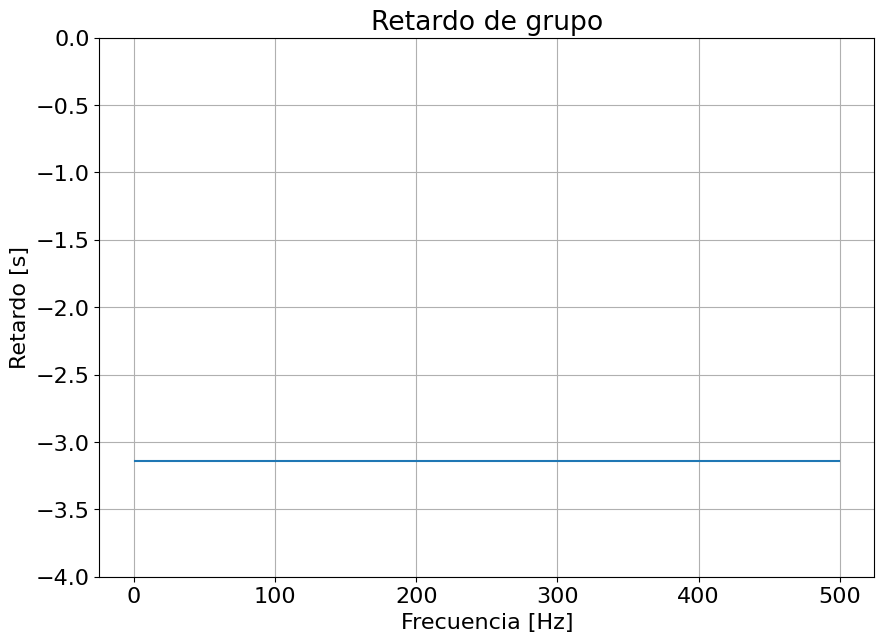

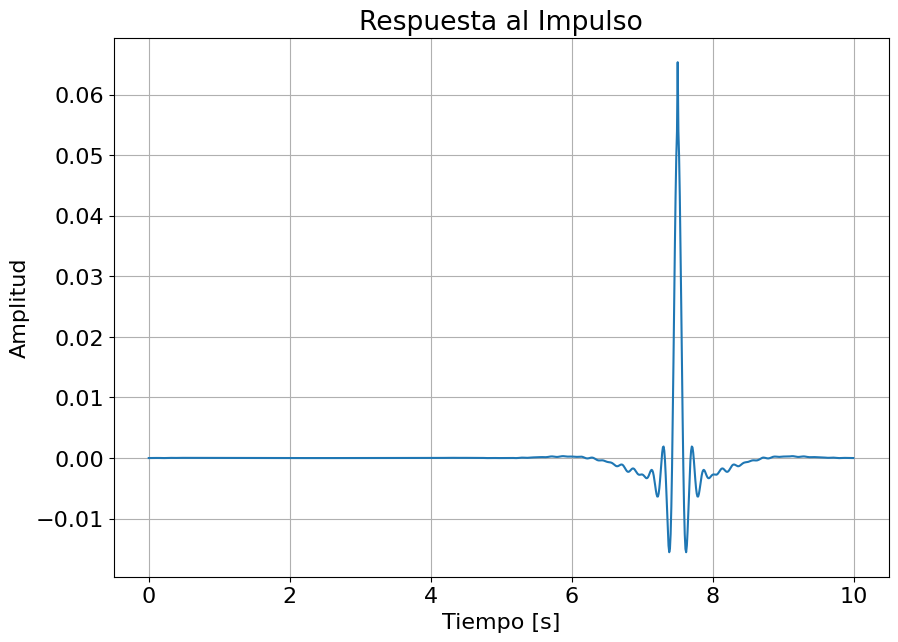

In [30]:
cant_coef = 3001

fir_win = sig.firwin2(cant_coef, frecs, gains , window='blackmanharris', fs=fs)

w_h, h = sig.freqz(fir_win, 1, worN = 1000)
f_h = w_h/np.pi * nyq_frec

fase = np.unwrap(np.angle(h))
gd = -np.diff(np.unwrap(np.angle(h)))/np.diff(f_h) #-dphi/df

t = np.arange(0, 10, 0.01)
imp = np.fft.ifft(h)

plt.figure()
plt.title('Modulo')
plt.plot(f_h, 20 * np.log10(abs(h)))
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0,100,-50, 5])

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]], ripple = ripple, 
               fstop = frecs[[1, 4]], attenuation = atenuacion, fs = fs)

plt.figure()
plt.title('Fase')
angles = np.unwrap(np.angle(h))
plt.plot(f_h, angles)
plt.ylabel('Fase [$\pi$ rad]')
plt.xlabel('Frecuencia [Hz]')
plt.grid()

plt.figure()
plt.title('Retardo de grupo')
plt.plot(f_h[1:], gd)
plt.ylabel('Retardo [s]')
plt.xlabel('Frecuencia [Hz]')
plt.ylim([-4,0])
plt.grid()

plt.figure()
plt.title('Respuesta al Impulso')
plt.plot(t, imp)
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.grid()

## Parte II: Implementación

In [60]:
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

## Filtrado con IIR

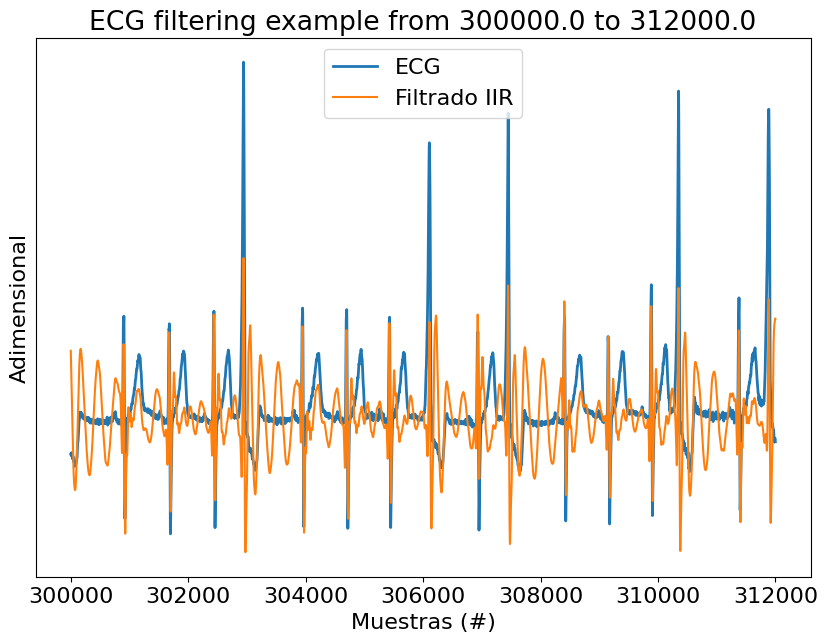

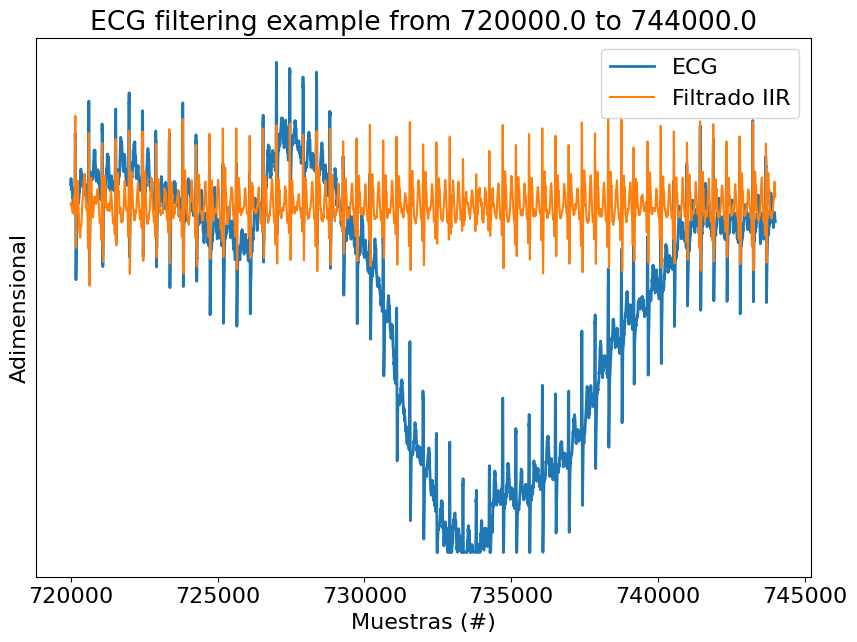

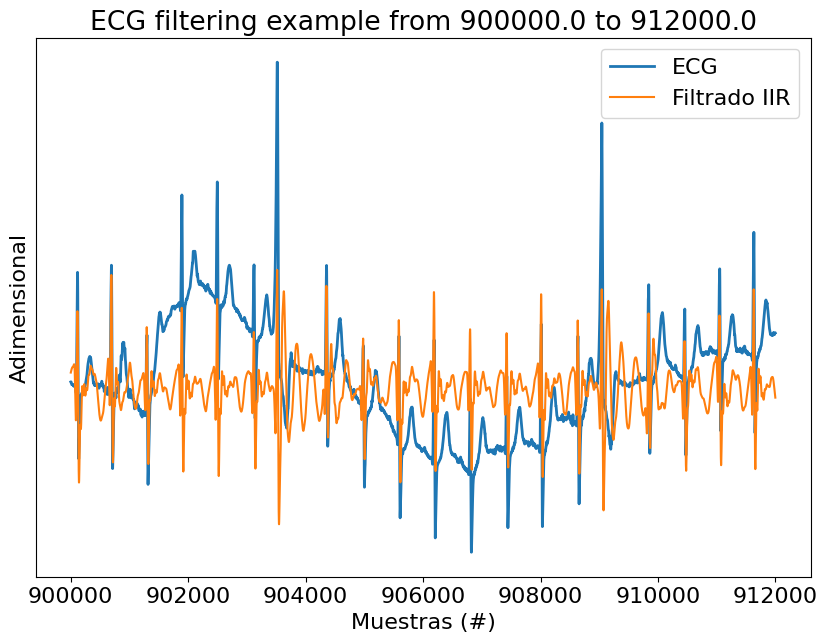

In [63]:
ECG_f_win = sig.sosfilt(sos_iir, ecg_one_lead)

demora = 115

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Filtrado IIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

## Filtrado bidireccional con IIR

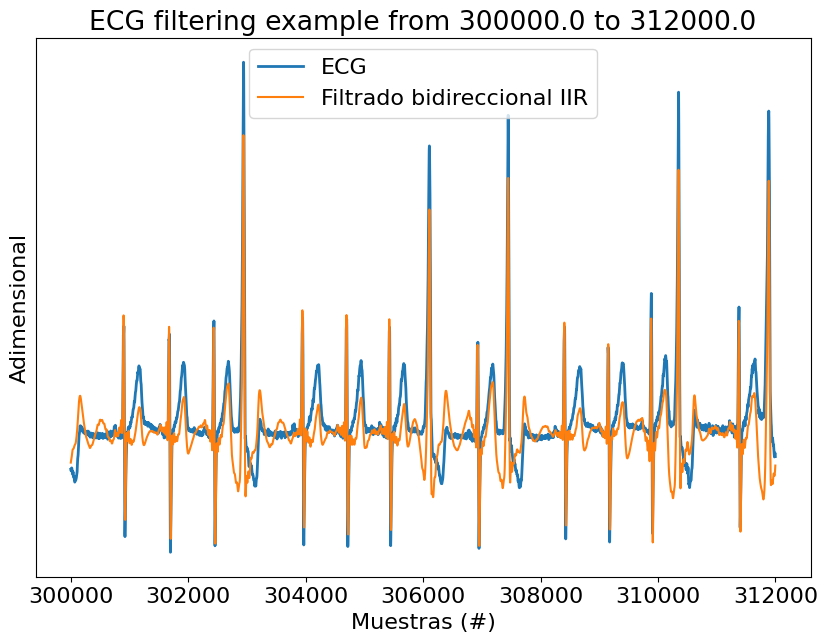

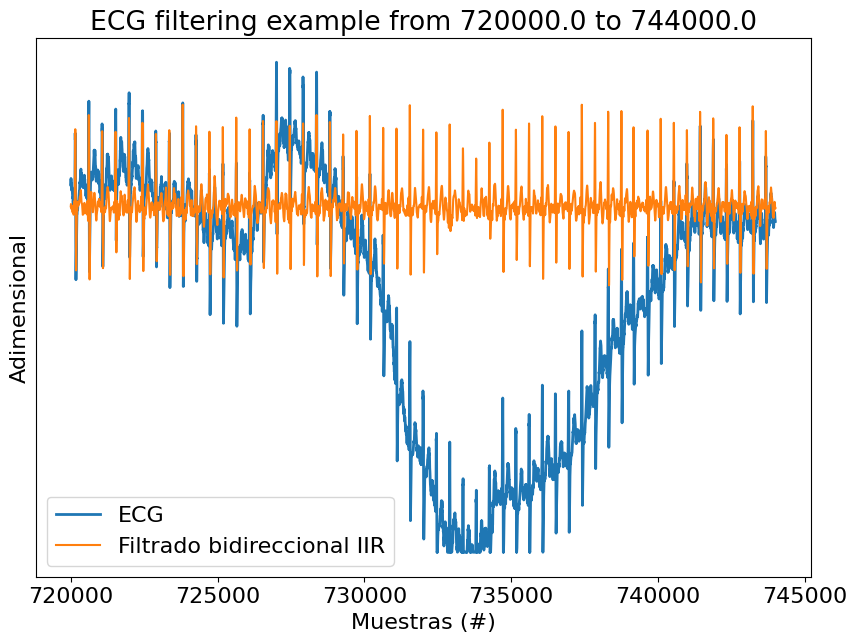

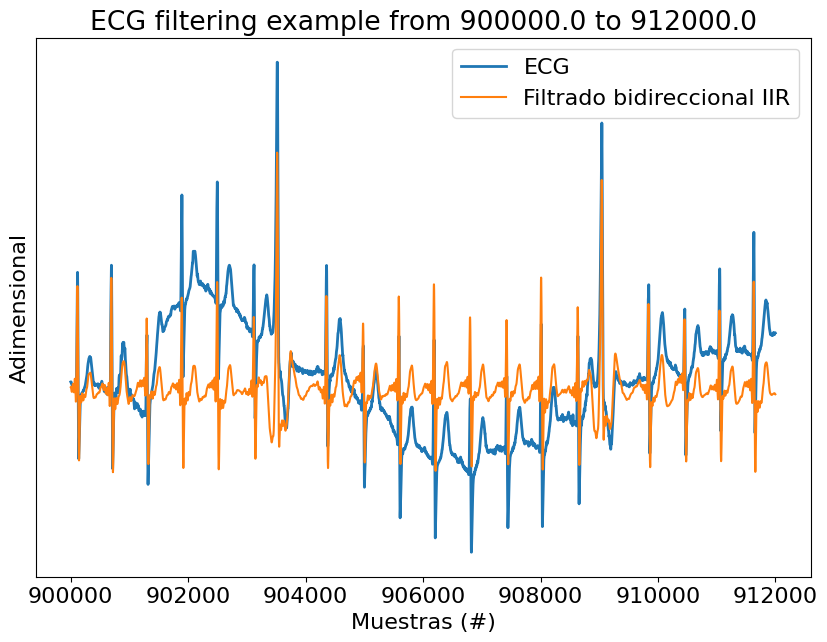

In [82]:
ECG_f_win = sig.sosfiltfilt(sos_iir, ecg_one_lead)

demora = 115

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Filtrado bidireccional IIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

## Filtrado con FIR

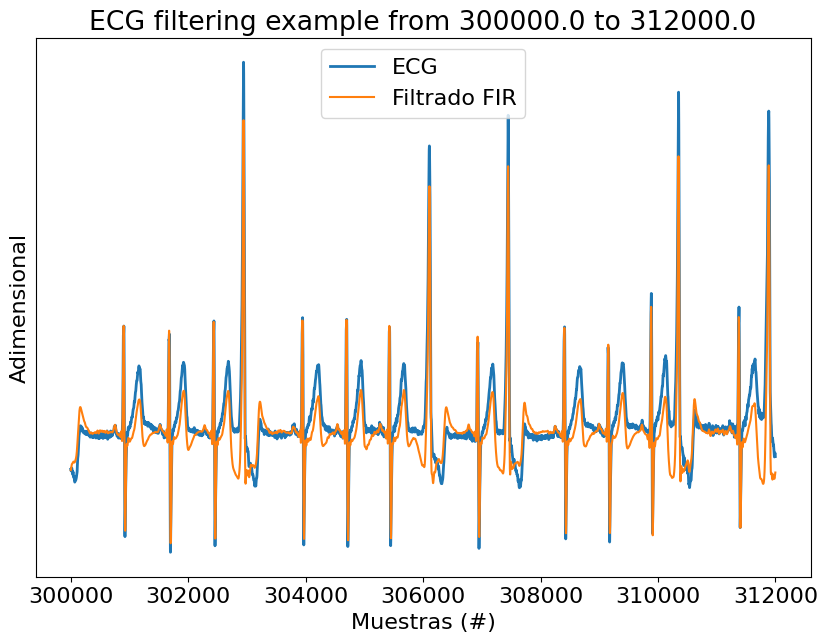

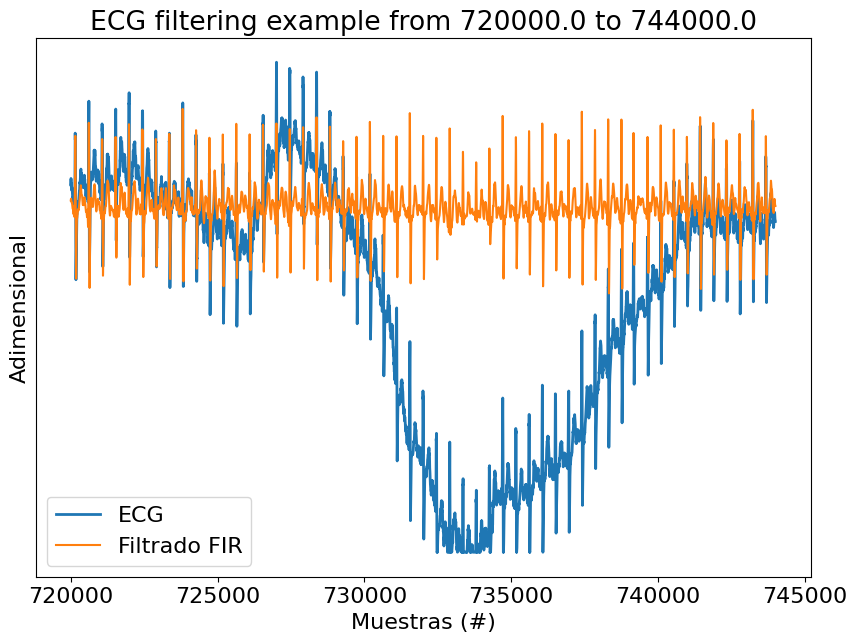

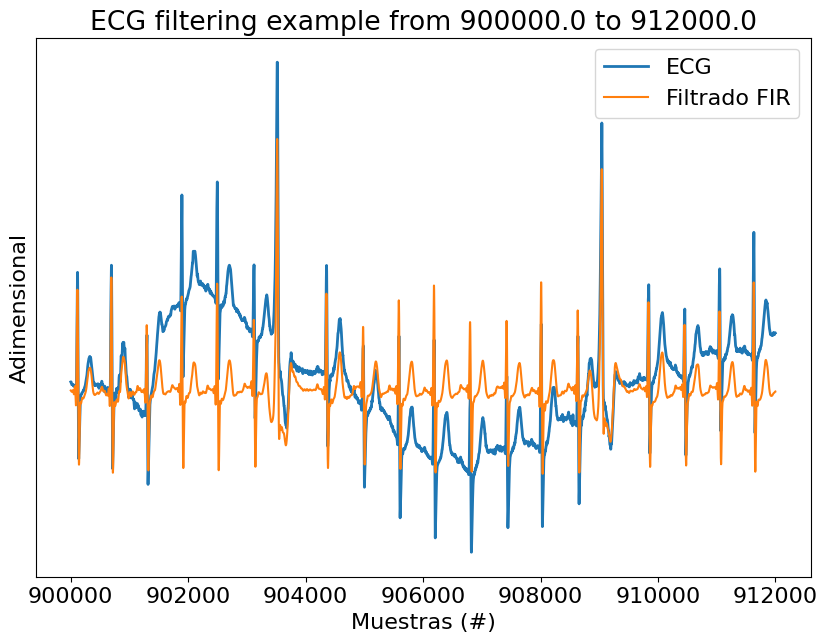

In [80]:
ECG_f_win = sig.lfilter(fir_win, 1, ecg_one_lead)

demora_fir = 1500

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora_fir], label='Filtrado FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

## Filtrado bidireccional con FIR

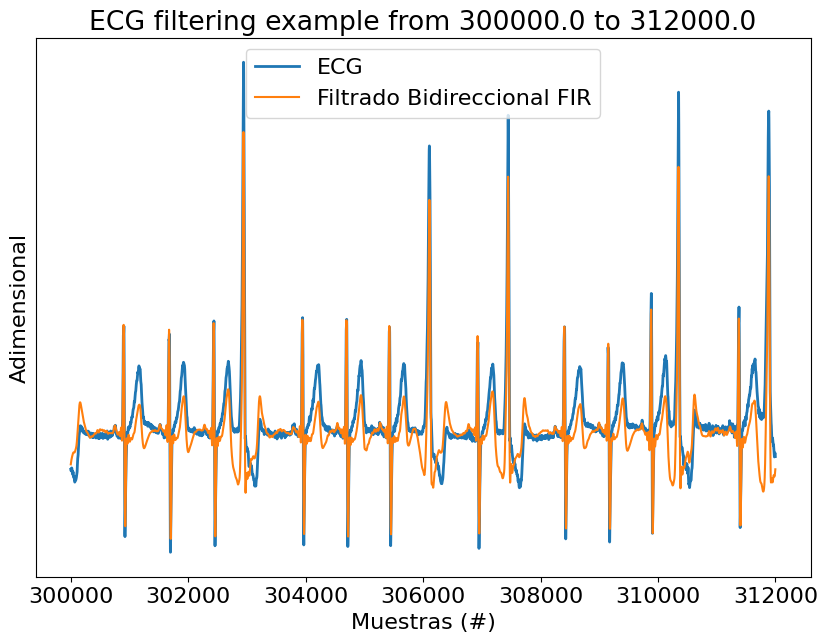

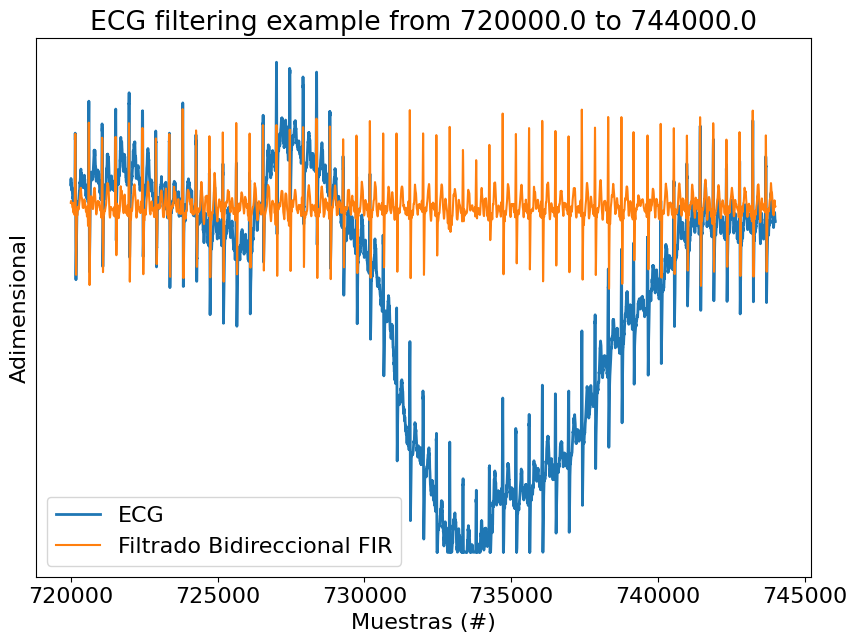

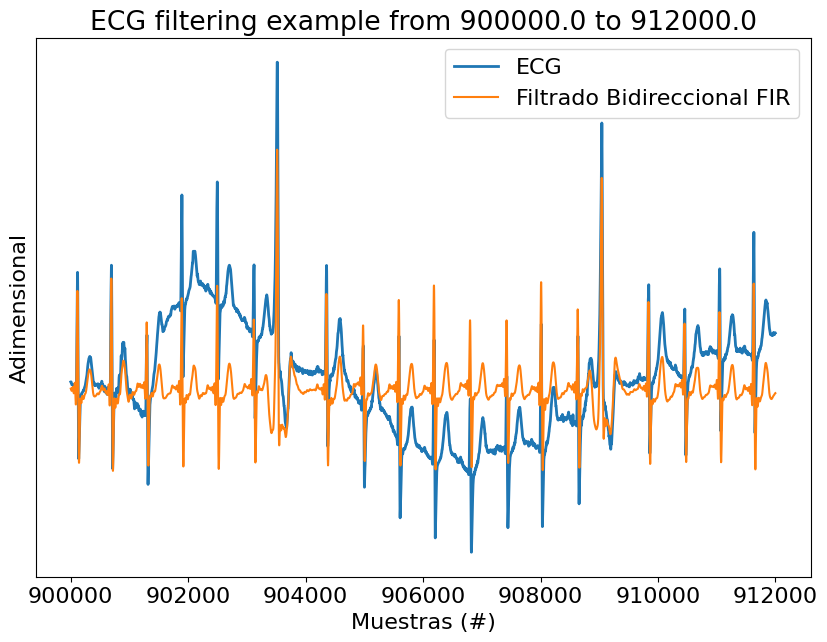

In [83]:
ECG_f_win = sig.filtfilt(fir_win, 1, ecg_one_lead)

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Filtrado Bidireccional FIR')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

## Conclusiones

En principio, se puede observar que todas las formas de filtrado son eficaces frente a la contaminación de baja frecuencia. 

El filtrado unidireccional IIR conserva correctamente los picos de la señal pero introduce oscilaciones que distorsionan completamente la forma de onda.

El filtrado bidireccional IIR no parece introducir oscilaciones y la señal filtrada guarda mucha mayor similitud con la señal original, aunque los eventos entre pulsos se ven muy atenuados.

Ambas formas de filtrado FIR guardan mayor similitud con respecto a la señal original y son prácticamente indistinguibles entre sí, aunque se siguen viendo atenuados los picos de mayor amplitud y los eventos entre pulsos. 